# Recent Surveys

This notebook evaluates the most recent surveys and is a benchmark to see how good we can predict consumption using the public available data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/src

/content/drive/MyDrive/src


In [ ]:
!pip install world-bank-data

In [5]:
from lib import estimator_util as eu
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

In [6]:
sns.set_theme()

In [7]:
continent: str = 'africa'
models: list = range(3)
model_names: list = ['ResNet18', 'ResNet50', 'ResNet152']

In [9]:
complete_dfs: list = []
all_cols_list: list = []

for model in models:
  complete_df, all_cols = eu.get_data(f"../data/continents/{continent}/lsms/processed/_all_real.csv", f"../data/continents/{continent}/model_{model}/cnn_features/cnn.csv", f"../data/continents/{continent}/")
  complete_dfs.append(complete_df)
  all_cols_list.append(all_cols_list)

In [10]:
countries: list = ["NG", "ETH" ,"TZA", "MW", "UGA", "NER", "MLI"]

## Predict $r^2$ for every country in our dataset.

In [11]:
def cnn_osm(complete, j):
    for i, country in enumerate(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        r2, y_hest, model = eu.run_ridge(X, y, alpha=1000, seed=1)
        fig = eu.plot_predictions(y, y_hest, r2, country, year, i)
        fig.savefig(f"../data/continents/{continent}/{model_names[j]}/figs/{country}_{year}_cnnosm.pdf", dpi=600)

0
1
2


/content/drive/MyDrive/src/lib/estimator_util.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5, 8))


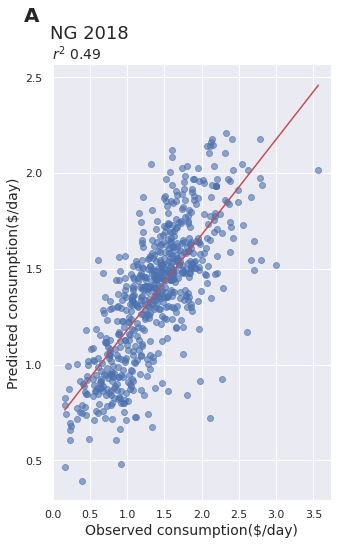

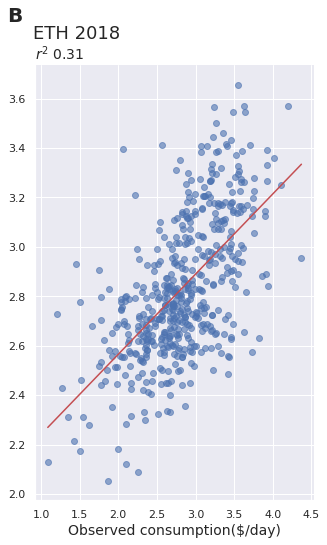

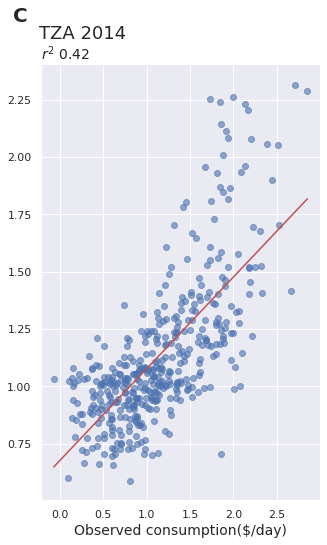

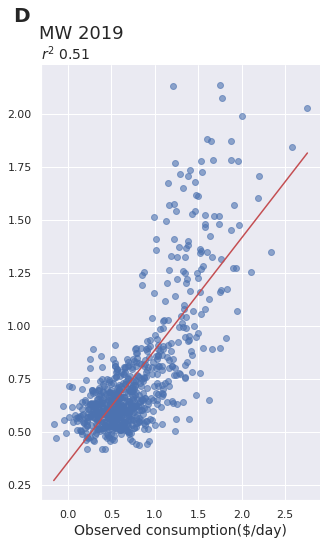

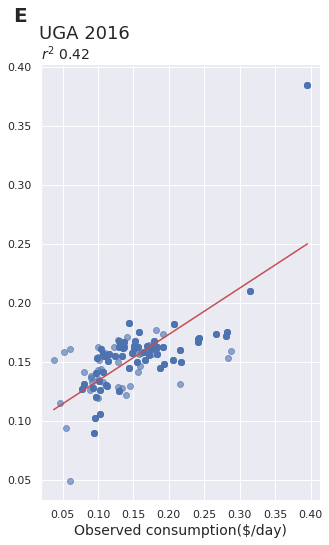

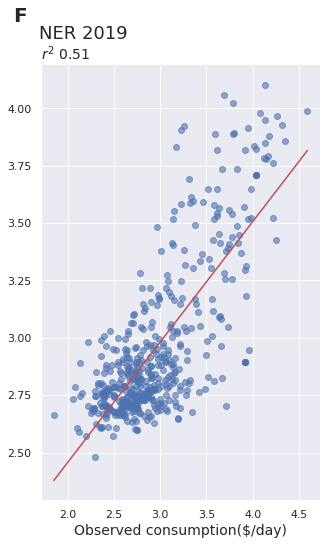

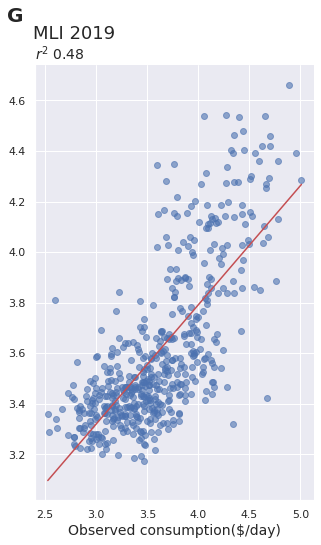

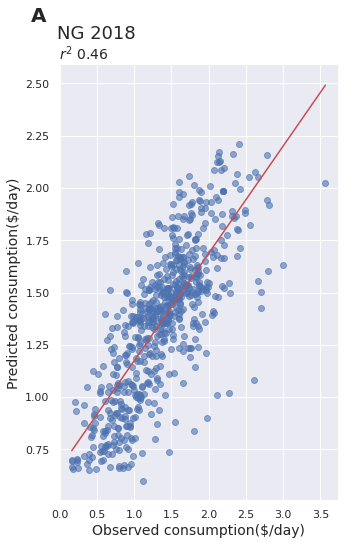

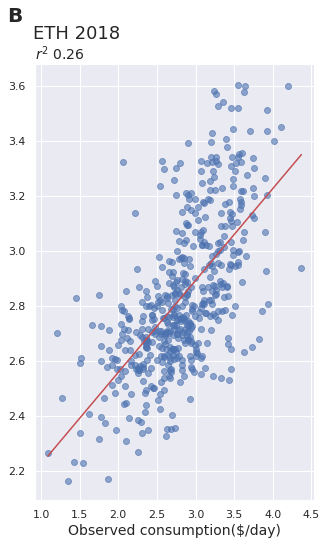

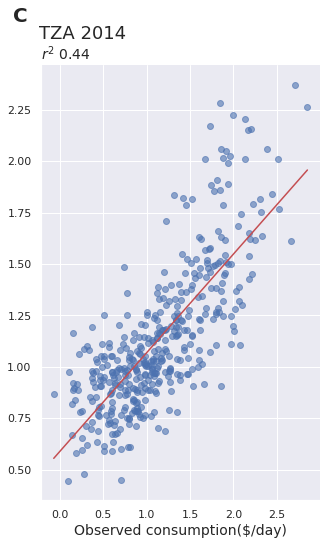

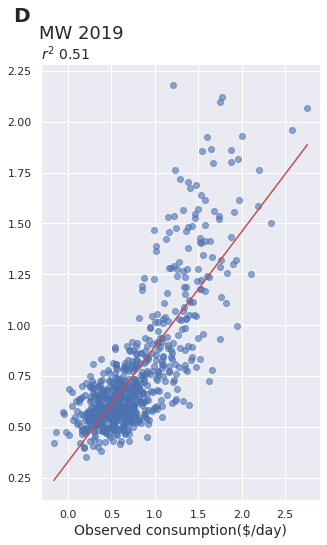

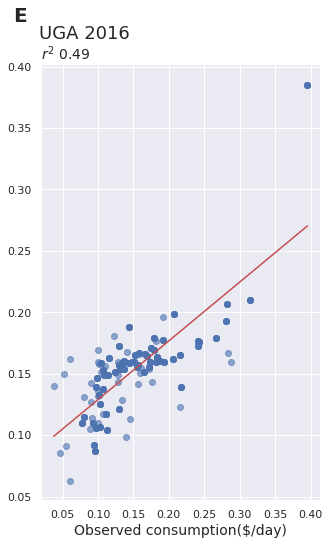

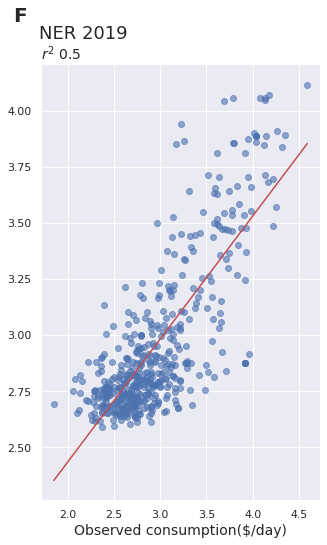

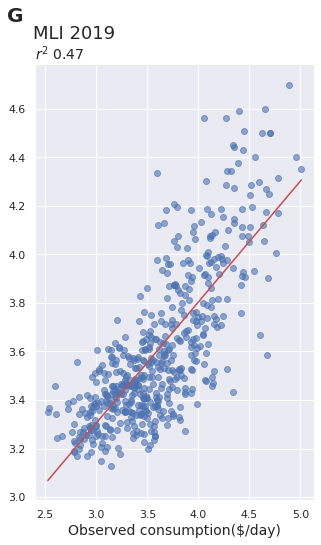

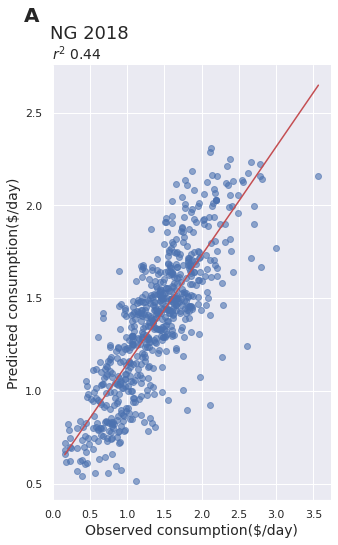

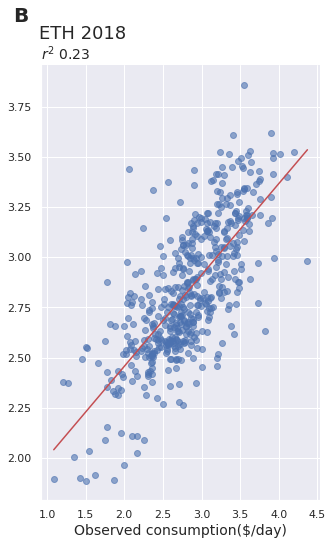

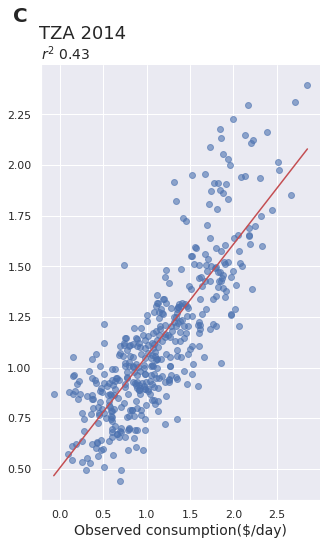

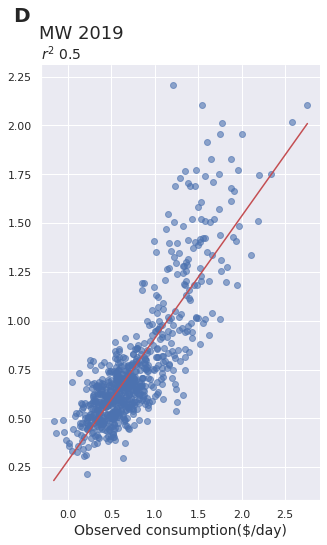

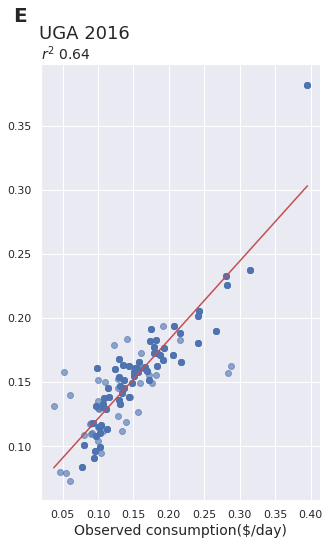

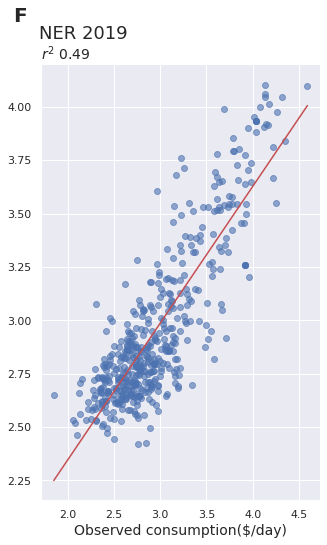

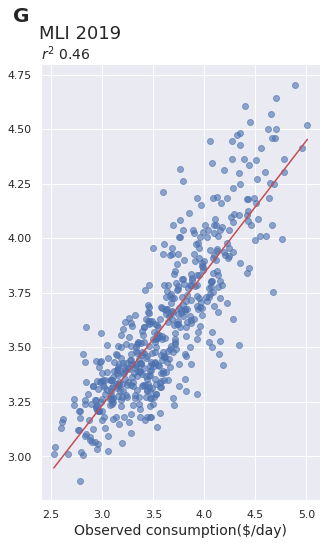

In [12]:
for i, complete_df in enumerate(complete_dfs):
    print(f'{model_names[i]}:')
    cnn_osm(complete_df, i)

## Rural vs. Urban

In [13]:
def rural_urban(complete, j):    
    types = ["rural", "urban"]
    types_r2 = {}
    rural = []
    ys = []
    y_preds = []
    # get features
    for type in types:    
        r2s = []
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            year_df = year_df.loc[year_df.rural == type]
            rural += year_df.rural.values.tolist()
            cnn_X = np.array([np.array(x) for x in year_df["features"].values])
            osm_X = year_df[all_cols].values
            tmp_X = np.hstack((cnn_X, osm_X))
            y_ = year_df["cons_pc"].values

            if X is None:
                X = tmp_X
            else:
                X = np.vstack((X, tmp_X))

            # Apply log(1 + x) to uganda, since they're mainly close to 0
            if country == 'UGA':
                y_ = np.log1p(y_)   
            else:       
                y_ = np.log(y_) 

            if y is None:
                y = y_
            else:
                y = np.append(y, y_)

        ys += y.tolist()
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        r, y_hest, _ = eu.run_ridge(X, y, alpha=1000)
        y_preds += y_hest.tolist()
        r2s.append(r)
        types_r2[type] = r2s

    # for the plot
    plt_df = pd.DataFrame.from_dict({"y": ys, "y_pred": y_preds, "rural": rural})

    x_col = "y"
    y_col = "y_pred"
    hue_col = "rural"

    penguins = plt_df
    g = sns.jointplot(data=penguins, x=x_col, y=y_col, hue=hue_col)
    
    for _, gr in penguins.groupby(hue_col):
        sns.regplot(x=x_col, y=y_col, data=gr, scatter=False, ax=g.ax_joint, truncate=False)
    print(types_r2)
    g.ax_joint.set_xlabel("Observed nominal consumption($/day)")
    g.ax_joint.set_ylabel("Predicted nominal consumption($/day)")
    plt.text(-0.8, 1, fr"$r^2 = {round(types_r2['rural'][0], 2)}$", c="#4c72b0")
    plt.text(-0.8, 0.8, fr"$r^2 = {round(types_r2['urban'][0], 2)}$", c="#dd8452")
    plt.legend([],[], frameon=False)
    g.ax_joint.get_legend().remove()
    g.ax_joint.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=g.ax_joint.transAxes)
    plt.savefig(f"../data/continents/{continent}/{model_names[j]}/figs/rural_urban_pop.pdf", dpi=600, bbox_inches="tight")


{'rural': [0.5259389912640295], 'urban': [0.6035645142279091]}
{'rural': [0.5249839910793541], 'urban': [0.6204338362334759]}
{'rural': [0.5592783844115192], 'urban': [0.657572135850309]}


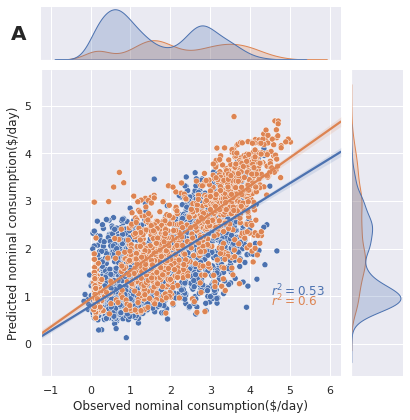

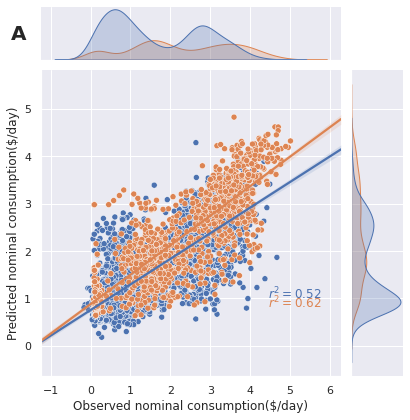

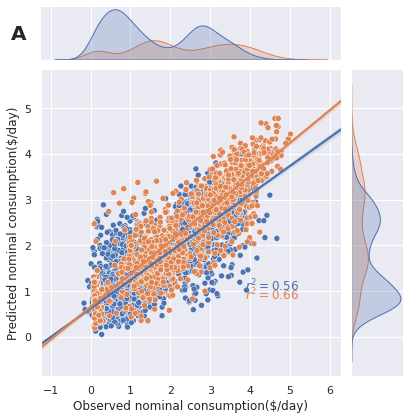

In [14]:
for i, complete_df in enumerate(complete_dfs):
    rural_urban(complete_df, i)

## Predict % of poorest people in dataset

In [15]:
def pooled_features_perc(complete, j):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []
        for i in tqdm(np.linspace(0.1,1,91)):
            perc_df = complete.loc[complete.cons_pc <= complete.cons_pc.quantile(i)]
            X = None
            y = None
            for i, country in enumerate(countries):
                tmp_df = perc_df.loc[perc_df.country == country]
                years = tmp_df.groupby(["year"]).groups.keys()
                if len(years) == 0:
                    continue
                year = max(years)
                year_df = tmp_df.loc[tmp_df.year == year]
                if feature == "CNN":
                    tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                elif feature == "OSM":
                    tmp_X = year_df[all_cols].values
                else:
                    cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                    osm_X = year_df[all_cols].values
                    tmp_X = np.hstack((cnn_X, osm_X))
                    
                y_ = year_df["cons_pc"].values

                # Log(1+x) to avoid negative values on Uganda
                if country == 'UGA':
                    y_ = np.log1p(y_)   
                else:       
                    y_ = np.log(y_) 

                if X is None:
                    X = tmp_X
                else:
                    X = np.vstack((X, tmp_X))
                
                if y is None:
                    y = y_
                else:
                    y = np.append(y, y_)

            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r, _, _ = eu.run_ridge(X, y, alpha=1000)
            r2s.append(r)
        feature_r2[feature] = r2s
    
    colors = ["#2a9d8f", "#e9c46a", "#e76f51"]
    for i, feature in enumerate(feature_r2):
        plt.plot(np.linspace(0.1,1,91)*100, feature_r2[feature], c=colors[i], label=feature)
    
    plt.xlabel("Poorest percent of cluster used")
    plt.ylabel(r"$r^2$")
    plt.legend()
    ax = plt.gca()
    ax.text(-0.1, 1.1, string.ascii_uppercase[1], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig(f"../data/continents/{continent}/{model_names[j]}/figs/pooled_percentile.pdf", dpi=600, bbox_inches="tight")
    plt.show()

100%|██████████| 91/91 [02:01<00:00,  1.33s/it]


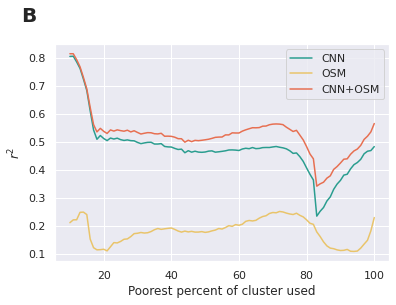

100%|██████████| 91/91 [09:37<00:00,  6.35s/it]


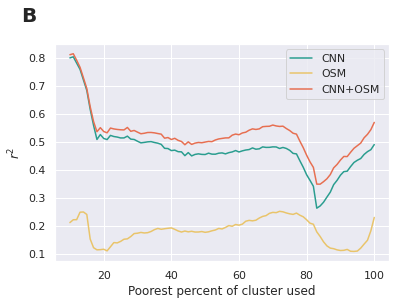

100%|██████████| 91/91 [09:48<00:00,  6.47s/it]


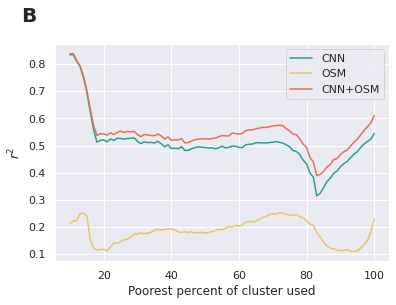

In [16]:
for i, complete_df in enumerate(complete_dfs):
    pooled_features_perc(complete_df, i)

## Predicting performance from each feature alone and combined

In [17]:
def prediction_features_performance(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []        
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            if feature == "CNN":
                tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                tmp_X = StandardScaler().fit_transform(tmp_X)
            elif feature == "OSM":
                tmp_X = year_df[all_cols].values
            else:
                cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                osm_X = year_df[all_cols].values
                tmp_X = np.hstack((cnn_X, osm_X))
                
            y = year_df["cons_pc"].values

            X = tmp_X
            if country != 'UGA':
               y = np.log(y)
            else:
               y = np.log1p(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r, _, _ = eu.run_ridge(X, y, alpha=1000)
            r2s.append(r)
            feature_r2[feature] = r2s
            
    feat_df = pd.DataFrame.from_dict(feature_r2)
    feat_df["country"] = countries
    return feat_df

In [18]:
for complete_df in complete_dfs:
    print(prediction_features_performance(complete_df))

        CNN       OSM   CNN+OSM country
0  0.355670  0.341560  0.486244      NG
1  0.182830  0.246082  0.307679     ETH
2  0.099695  0.406537  0.412468     TZA
3  0.124735  0.473509  0.507070      MW
4  0.298707  0.321306  0.440370     UGA
5  0.367905  0.490771  0.538820     NER
6  0.319387  0.449307  0.475905     MLI
        CNN       OSM   CNN+OSM country
0  0.344408  0.341560  0.464249      NG
1  0.125330  0.246082  0.247944     ETH
2  0.258983  0.406537  0.437298     TZA
3  0.115661  0.473509  0.490340      MW
4  0.395406  0.321306  0.511058     UGA
5  0.368652  0.490771  0.520532     NER
6  0.266805  0.449307  0.455141     MLI
        CNN       OSM   CNN+OSM country
0  0.350143  0.341560  0.452595      NG
1  0.142809  0.246082  0.201825     ETH
2  0.309698  0.406537  0.426873     TZA
3  0.209991  0.473509  0.482281      MW
4  0.526614  0.321306  0.623600     UGA
5  0.357694  0.490771  0.508746     NER
6  0.283243  0.449307  0.451125     MLI
